# Nissen et al., 2023: Severe 21st-century OA in Antarctic MPAs
#
# Fig. S3: Climate-change impacts on air-sea CO2 fluxes

In [1]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata
from matplotlib import cm
from netCDF4 import Dataset, MFDataset
import pandas as pd
from tqdm import tqdm

In [4]:
#------
# General info
#------

# path to model data (air-sea CO2 flux)
path_to_data = '/pscratch/sd/c/cnissen/COARZE_CO2/' 
# code expects subfolders simA_hist,simC_hist,ssp245,ssp585,simC_ssp245,simC_ssp585

# path to masks of MPAs (on original FESOM mesh)
path_to_mask = '/pscratch/sd/c/cnissen/HLRN_runs_postprocessed/masks/masks_MPAs/'

savepath    = '/global/cfs/cdirs/m4003/cnissen/Plots/Paper_OA_in_MPAs/Fig_climate_change_effect_CO2/'
if not os.path.exists(savepath):
    print('Created '+savepath)
    os.makedirs(savepath)

savepath2    = savepath+'eps/'
if not os.path.exists(savepath2):
    print('Created '+savepath2)
    os.makedirs(savepath2)
    
#---
# load mesh info
#---

path_mesh = '/pscratch/sd/c/cnissen/'
file_mesh = 'Nissen2022_FESOM_REcoM_mesh_information_corrected_20220910.nc'

f1 = Dataset(path_mesh+file_mesh) #xr.open_dataset(path+file1)
lat_model      = f1.variables['lat'][:]
lon_model      = f1.variables['lon'][:]
zlevs    = f1.variables['zlevs'][:]
cavities = f1.variables['cavity'][:]
topo     = f1.variables['topo'][:]
area     = f1.variables['cell_area'][:]
volume   = f1.variables['cell_volume'][:]
f1.close()
print(lat_model.shape)

ind_no_cavity = np.where(cavities==0)[0]
ind_cavities = np.where(cavities==1)[0]


(72411,)


In [5]:
#-----
# load model data 
#-----

vari = 'CO2f'

years_plot1 = np.arange(1990,1999+1,1)
years_plot2 = np.arange(2090,2099+1,1)

data_A_hist   = -999*np.ones([len(lon_model),12,len(years_plot1)]) # simA, 1990s
data_A_ssp245 = -999*np.ones([len(lon_model),12,len(years_plot2)]) # simA, 2090s
data_A_ssp585 = -999*np.ones([len(lon_model),12,len(years_plot2)]) # simA, 2090s

data_C_hist   = -999*np.ones([len(lon_model),12,len(years_plot1)]) # simA, 1990s
data_C_ssp245 = -999*np.ones([len(lon_model),12,len(years_plot2)]) # simA, 2090s
data_C_ssp585 = -999*np.ones([len(lon_model),12,len(years_plot2)]) # simA, 2090s

#---
# HISTORICAL
#---
for yy in tqdm(range(0,len(years_plot1))):
        
        #------
        # simA
        #------
        f1    = Dataset(path_to_data+'simA_hist/'+vari+'_fesom_'+str(years_plot1[yy])+'0101.nc') 
        data_A_hist[:,:,yy] = np.transpose(f1.variables[vari][:,:])
        f1.close()
        
        #------
        # simC
        #------
        f1    = Dataset(path_to_data+'simC_hist/'+vari+'_fesom_'+str(years_plot1[yy])+'0101.nc') 
        data_C_hist[:,:,yy] = np.transpose(f1.variables[vari][:,:])
        f1.close()
        
        
#---
# FUTURE/2090s
#---
for yy in tqdm(range(0,len(years_plot2))):
        
        #------
        # simA, ssp245
        #------
        f1    = Dataset(path_to_data+'ssp245/'+vari+'_fesom_'+str(years_plot2[yy])+'0101.nc') 
        data_A_ssp245[:,:,yy] = np.transpose(f1.variables[vari][:,:])
        f1.close()
        #------
        # simA, ssp585
        #------
        f1    = Dataset(path_to_data+'ssp585/'+vari+'_fesom_'+str(years_plot2[yy])+'0101.nc') 
        data_A_ssp585[:,:,yy] = np.transpose(f1.variables[vari][:,:])
        f1.close()
        
        #------
        # simC, ssp245
        #------
        f1    = Dataset(path_to_data+'simC_ssp245/'+vari+'_fesom_'+str(years_plot2[yy])+'0101.nc') 
        data_C_ssp245[:,:,yy] = np.transpose(f1.variables[vari][:,:])
        f1.close()
        #------
        # simC, ssp585
        #------
        f1    = Dataset(path_to_data+'simC_ssp585/'+vari+'_fesom_'+str(years_plot2[yy])+'0101.nc') 
        data_C_ssp585[:,:,yy] = np.transpose(f1.variables[vari][:,:])
        f1.close()
        
print ('done')


100%|██████████| 10/10 [00:02<00:00,  3.83it/s]

done


In [6]:
#---
# FUNCTION
#---

def get_indices_in_region(rr,subregions,path_to_mask):
    
    #----
    # get masks for MPAs
    #----
    f1 = Dataset(path_to_mask+'MPA_mask_AntarcticPeninsula_fesom_mesh_COARZE.nc')
    mask_WAP_MPA = f1.variables['mask_fesom'][:]
    f1.close()
    f1 = Dataset(path_to_mask+'MPA_mask_East_Antarctica_1_fesom_mesh_COARZE.nc')
    mask_eastAA1_MPA = f1.variables['mask_fesom'][:]
    f1.close()
    f1 = Dataset(path_to_mask+'MPA_mask_East_Antarctica_2_fesom_mesh_COARZE.nc')
    mask_eastAA2_MPA = f1.variables['mask_fesom'][:]
    f1.close()
    f1 = Dataset(path_to_mask+'MPA_mask_East_Antarctica_3_fesom_mesh_COARZE.nc')
    mask_eastAA3_MPA = f1.variables['mask_fesom'][:]
    f1.close()
    f1 = Dataset(path_to_mask+'MPA_mask_Orkney_fesom_mesh_COARZE.nc')
    mask_Orkney_MPA = f1.variables['mask_fesom'][:]
    f1.close()
    f1 = Dataset(path_to_mask+'MPA_mask_RossSea_fesom_mesh_COARZE.nc')
    mask_RossSea_MPA = f1.variables['mask_fesom'][:]
    f1.close()
    f1 = Dataset(path_to_mask+'MPA_mask_WeddellSea_fesom_mesh_COARZE.nc')
    mask_WeddellSea_MPA = f1.variables['mask_fesom'][:]
    f1.close()

    if subregions[rr] in ['RossSea_MPA']:
        ind_regions = np.where((mask_RossSea_MPA==1) & (cavities==0))[0]
    elif subregions[rr] in ['RossSea_MPA_shelf']:
        ind_regions = np.where((mask_RossSea_MPA==1) & (cavities==0) & (topo<=2000))[0]
    elif subregions[rr] in ['RossSea_MPA_openOcean']:
        ind_regions = np.where((mask_RossSea_MPA==1) & (cavities==0) & (topo>2000))[0]
    elif subregions[rr] in ['WeddellSea_MPA']:
        ind_regions = np.where((mask_WeddellSea_MPA==1) & (cavities==0))[0]
    elif subregions[rr] in ['WeddellSea_MPA_shelf']:
        ind_regions = np.where((mask_WeddellSea_MPA==1) & (cavities==0) & (topo<=2000))[0]
    elif subregions[rr] in ['WeddellSea_MPA_openOcean']:
        ind_regions = np.where((mask_WeddellSea_MPA==1) & (cavities==0) & (topo>2000))[0]
    elif subregions[rr] in ['AntarcticPeninsula_MPA']:
        ind_regions = np.where((mask_WAP_MPA==1) & (cavities==0))[0]
    elif subregions[rr] in ['AntarcticPeninsula_MPA_shelf']:
        ind_regions = np.where((mask_WAP_MPA==1) & (cavities==0) & (topo<=2000))[0]
    elif subregions[rr] in ['AntarcticPeninsula_MPA_openOcean']:
        ind_regions = np.where((mask_WAP_MPA==1) & (cavities==0) & (topo>2000))[0]
    elif subregions[rr] in ['Orkney_MPA']:
        ind_regions = np.where((mask_Orkney_MPA==1) & (cavities==0))[0]
    elif subregions[rr] in ['Orkney_MPA_shelf']:
        ind_regions = np.where((mask_Orkney_MPA==1) & (cavities==0) & (topo<=2000))[0]
    elif subregions[rr] in ['Orkney_MPA_openOcean']:
        ind_regions = np.where((mask_Orkney_MPA==1) & (cavities==0) & (topo>2000))[0]
            
            
    elif subregions[rr] in ['East_Antarctica_1_MPA']:
        ind_regions = np.where((mask_eastAA1_MPA==1) & (cavities==0))[0]
    elif subregions[rr] in ['East_Antarctica_1_MPA_shelf']:
        ind_regions = np.where((mask_eastAA1_MPA==1) & (cavities==0) & (topo<=2000))[0]
    elif subregions[rr] in ['East_Antarctica_1_MPA_openOcean']:
        ind_regions = np.where((mask_eastAA1_MPA==1) & (cavities==0) & (topo>2000))[0]
    elif subregions[rr] in ['East_Antarctica_2_MPA']:
        ind_regions = np.where((mask_eastAA2_MPA==1) & (cavities==0))[0]
    elif subregions[rr] in ['East_Antarctica_2_MPA_shelf']:
        ind_regions = np.where((mask_eastAA2_MPA==1) & (cavities==0) & (topo<=2000))[0]
    elif subregions[rr] in ['East_Antarctica_2_MPA_openOcean']:
        ind_regions = np.where((mask_eastAA2_MPA==1) & (cavities==0) & (topo>2000))[0]
    elif subregions[rr] in ['East_Antarctica_3_MPA']:
        ind_regions = np.where((mask_eastAA3_MPA==1) & (cavities==0))[0]
    elif subregions[rr] in ['East_Antarctica_3_MPA_shelf']:
        ind_regions = np.where((mask_eastAA3_MPA==1) & (cavities==0) & (topo<=2000))[0]
    elif subregions[rr] in ['East_Antarctica_3_MPA_openOcean']:
        ind_regions = np.where((mask_eastAA3_MPA==1) & (cavities==0) & (topo>2000))[0]
            
    elif subregions[rr] in ['East_Antarctica_all_MPA']:
        ind_regions = np.where(((mask_eastAA1_MPA==1) | (mask_eastAA2_MPA==1) | (mask_eastAA3_MPA==1) ) & (cavities==0))[0]
    elif subregions[rr] in ['East_Antarctica_all_MPA_shelf']:
        ind_regions = np.where(((mask_eastAA1_MPA==1) | (mask_eastAA2_MPA==1) | (mask_eastAA3_MPA==1) ) & (cavities==0) & (topo<=2000))[0]
    elif subregions[rr] in ['East_Antarctica_all_MPA_openOcean']:
        ind_regions = np.where(((mask_eastAA1_MPA==1) | (mask_eastAA2_MPA==1) | (mask_eastAA3_MPA==1) ) & (cavities==0) & (topo>2000))[0]
    
    return ind_regions


In [7]:
#--------
# integrate over regions for fluxes: SO south of XX
# average over regions for tracer concentrations
#--------

#'all_shelves','WeddellSea','eWeddellSea','Prydz','Adelie','RossSea','Amundsen_Bellingshausen','WAP',\
 
# all regions defined in function 'get_indices_in_region()' above
mpa_regions = ['RossSea_MPA','RossSea_MPA_shelf','RossSea_MPA_openOcean',\
              'WeddellSea_MPA','WeddellSea_MPA_shelf','WeddellSea_MPA_openOcean',\
              'Orkney_MPA','AntarcticPeninsula_MPA',\
             'East_Antarctica_1_MPA','East_Antarctica_2_MPA','East_Antarctica_3_MPA','East_Antarctica_all_MPA',\
             'East_Antarctica_1_MPA_shelf','East_Antarctica_2_MPA_shelf',\
              'East_Antarctica_3_MPA_shelf','East_Antarctica_all_MPA_shelf',\
             'East_Antarctica_1_MPA_openOcean','East_Antarctica_2_MPA_openOcean',\
              'East_Antarctica_3_MPA_openOcean','East_Antarctica_all_MPA_openOcean',\
              'AntarcticPeninsula_MPA_openOcean','AntarcticPeninsula_MPA_shelf']

# chose regions of interest
regions = ['RossSea_MPA','RossSea_MPA_shelf',\
           'WeddellSea_MPA','WeddellSea_MPA_shelf',\
              'Orkney_MPA','AntarcticPeninsula_MPA',\
             'East_Antarctica_all_MPA','East_Antarctica_all_MPA_shelf',\
          'AntarcticPeninsula_MPA_shelf']

region_names = regions
       
data_A_hist_avg   = -999*np.ones([12,len(years_plot1),len(regions)])
data_A_ssp245_avg = -999*np.ones([12,len(years_plot2),len(regions)])
data_A_ssp585_avg = -999*np.ones([12,len(years_plot2),len(regions)])

data_C_hist_avg   = -999*np.ones([12,len(years_plot1),len(regions)])
data_C_ssp245_avg = -999*np.ones([12,len(years_plot2),len(regions)]) 
data_C_ssp585_avg = -999*np.ones([12,len(years_plot2),len(regions)]) 

for rr in range(0,len(regions)):
    print ('#------')
    print (regions[rr])
    print ('#------')
    
    try:
        ind_region = get_indices_in_region(rr,regions,path_to_mask)
    except:
        print ('function not available')
        if regions[rr] in ['south_of_60S_circumpolar']:
            ind_region = np.where(lat_model<-60 )[0]
    print (ind_region.shape)
        
    for mm in range(0,12):
        for yy in range(0,len(years_plot1)):
            # simA, hist
            data1 = data_A_hist[:,mm,yy]
            data1[data1==-999]=np.nan
            data_A_hist_avg[mm,yy,rr] = np.nansum(data1[ind_region]*area[ind_region]) 
            del data1
            # simC, hist
            data1 = data_C_hist[:,mm,yy]
            data1[data1==-999]=np.nan
            data_C_hist_avg[mm,yy,rr] = np.nansum(data1[ind_region]*area[ind_region]) 
            del data1
            # simA, ssp245
            data1 = data_A_ssp245[:,mm,yy]
            data1[data1==-999]=np.nan
            data_A_ssp245_avg[mm,yy,rr] = np.nansum(data1[ind_region]*area[ind_region]) 
            del data1
            # simA, ssp585
            data1 = data_A_ssp585[:,mm,yy]
            data1[data1==-999]=np.nan
            data_A_ssp585_avg[mm,yy,rr] = np.nansum(data1[ind_region]*area[ind_region]) 
            del data1
            # simC, ssp245
            data1 = data_C_ssp245[:,mm,yy]
            data1[data1==-999]=np.nan
            data_C_ssp245_avg[mm,yy,rr] = np.nansum(data1[ind_region]*area[ind_region]) 
            del data1
            # simC, ssp585
            data1 = data_C_ssp585[:,mm,yy]
            data1[data1==-999]=np.nan
            data_C_ssp585_avg[mm,yy,rr] = np.nansum(data1[ind_region]*area[ind_region]) 
            del data1
                    
                    
print ('done')


#------
RossSea_MPA
#------
(2464,)
#------
RossSea_MPA_shelf
#------
(2197,)
#------
WeddellSea_MPA
#------
(2043,)
#------
WeddellSea_MPA_shelf
#------
(1486,)
#------
Orkney_MPA
#------
(22,)
#------
AntarcticPeninsula_MPA
#------
(3632,)
#------
East_Antarctica_all_MPA
#------
(1250,)
#------
East_Antarctica_all_MPA_shelf
#------
(942,)
#------
AntarcticPeninsula_MPA_shelf
#------
(3548,)
done


In [8]:
#----
# COLORS
#----

# Ross: deep aqua, ocean(7,87,91), wave, seafowm
color_list1 = [(0./255.,59./255.,70./255.),(102./255.,165./255.,173./255.),(196./255.,223./255.,230./255.),\
                  (0.82,0.82,0.82)]
# eastAA: olive green, sage, honeydew(226, 223, 162), cream(235,220,178), linen(234,226,214), fog
color_list2 = [(75./255.,116./255.,71./255.),(161./255.,190./255.,149./255.),(201./255.,209./255.,200./255.),\
                  (0.82,0.82,0.82)]
# Weddell: midnight blue (52, 77, 144)
color_list3 = [(26./255.,64./255.,95./255.),(51./255.,123./255.,174./255.),(208./255.,225./255.,249./255.),\
                  (0.82,0.82,0.82)]
# Orkney: red clay(164,56,32), bronze(192,88,5), carrot, desert(186, 85, 54), Canteloupe,  sunglow(217,180,74) (beige/sandstone)
color_list4 = [(164./255.,56./255.,32./255.),(238./255.,105./255.,36./255.),(248./255.,160./255.,85./255.),\
                  (0.82,0.82,0.82)]
# WAP: eggplant, pewter(134,118,102), warm grey, putty
color_list5 = [(80./255.,49./255.,47./255.),(186./255.,168./255.,150./255.),(230./255.,204./255.,181./255.),\
                  (0.82,0.82,0.82)]
# grey scale for areas that are not MPAs
color_list6 = [(0./255.,0./255.,0./255.),(75./255.,75./255.,75./255.),(150./255.,150./255.,150./255.),\
                  (0.82,0.82,0.82)]    
    

[1.59271171e+12 7.13687564e+11 1.44465317e+12 7.67114478e+11
 1.07698381e+11 5.59666889e+11 9.73921518e+11 2.78954967e+11
 4.10126320e+11]
RossSea_MPA


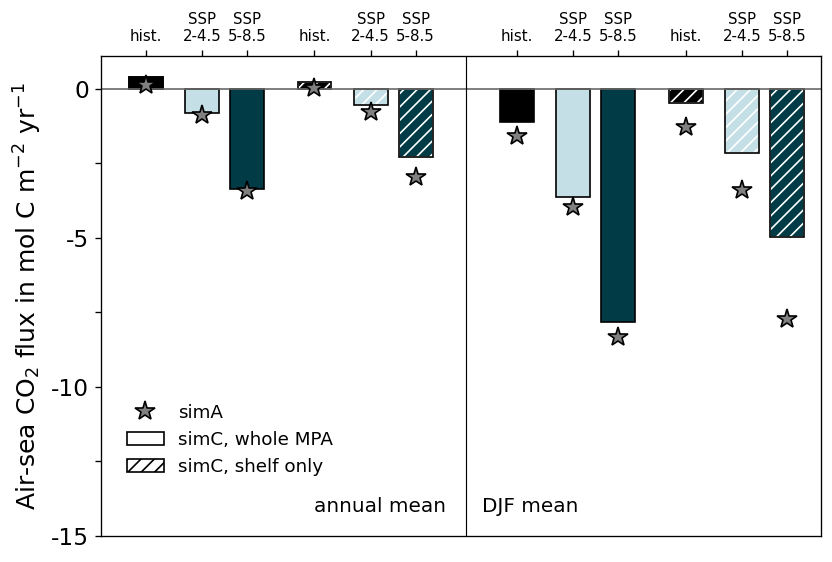

WeddellSea_MPA


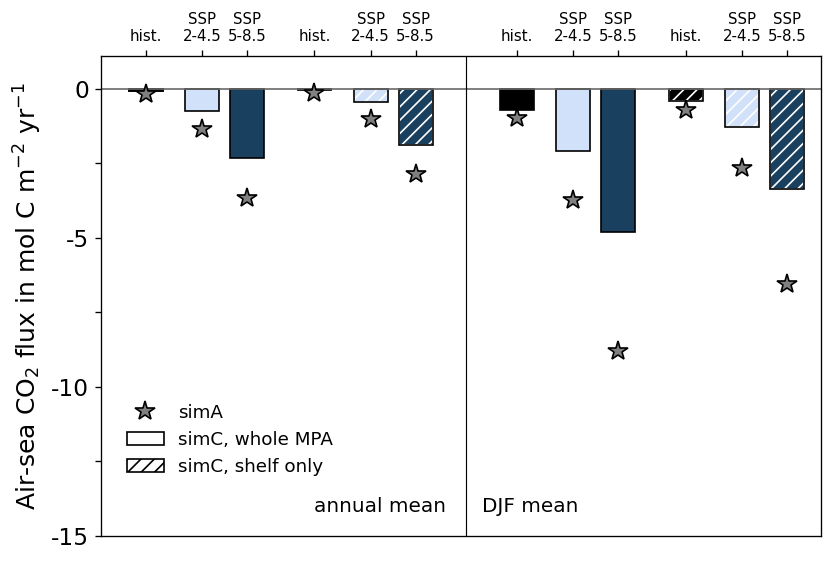

Orkney_MPA


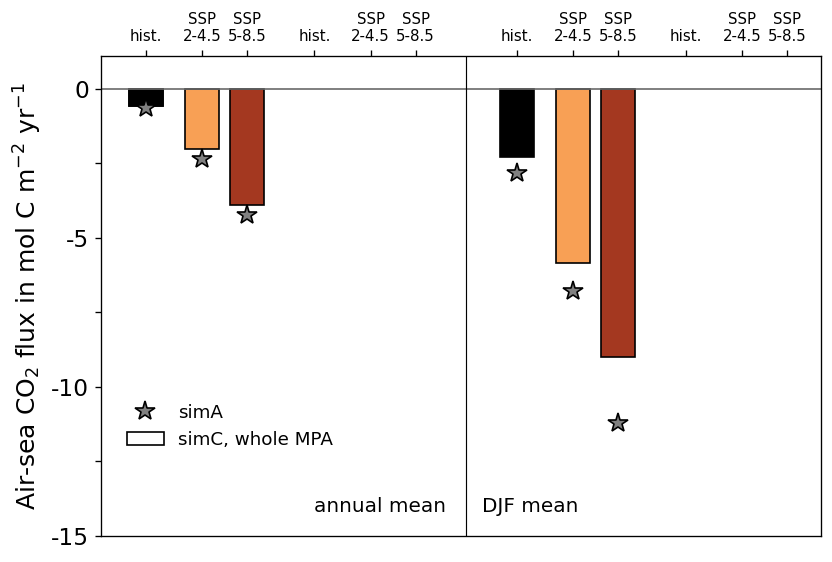

AntarcticPeninsula_MPA


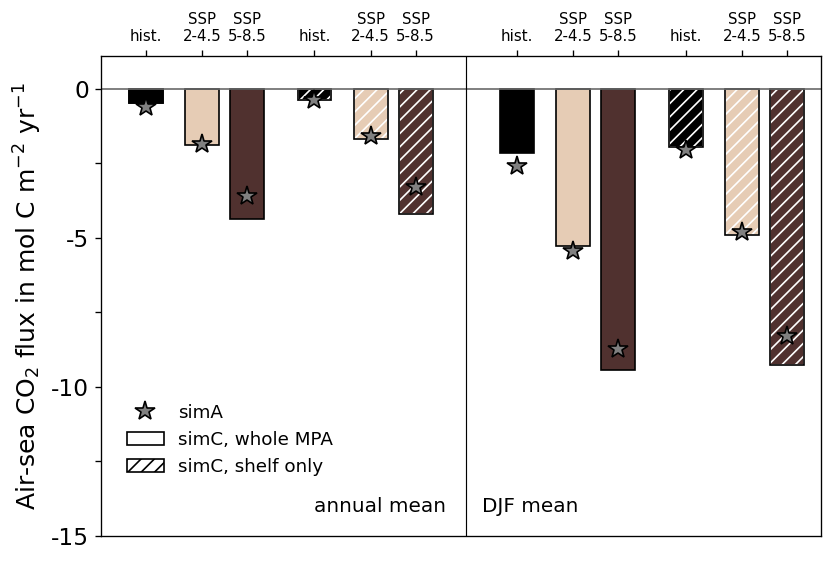

East_Antarctica_all_MPA


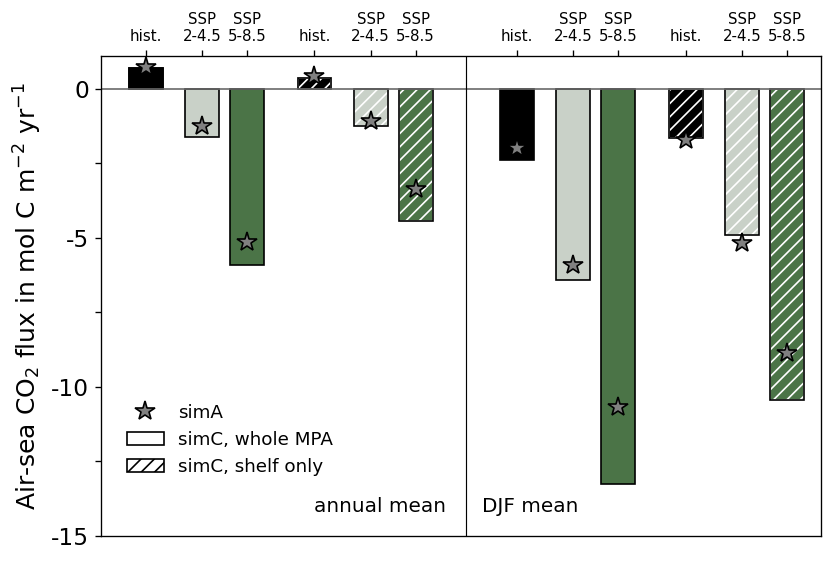

In [11]:
#----
# PLOT: climate-change impact on CO2 flux in 1990s vs 2090s, area-normalized
#----

display_plot = True
save_plot = False
plot_eps = False

reg_list = ['RossSea_MPA','WeddellSea_MPA','Orkney_MPA','AntarcticPeninsula_MPA','East_Antarctica_all_MPA']

shift = 0.1
width1 = 0.3
ec = 'k'
fs = 14

factorCO2 = -1*12.01*365.25/1e15

area_subregions = np.zeros(len(regions))
for rr in range(0,len(regions)):
    try:
        ind_region = get_indices_in_region(rr,regions,path_to_mask)
    except:
        #print 'function not available'
        if regions[rr] in ['south_of_60S_circumpolar']:
            ind_region = np.where(lat_model<-60 )[0]
            
    area_subregions[rr] = np.sum(area[ind_region])
    
print (area_subregions)

for rr in range(0,len(reg_list)):
    print (reg_list[rr])
    
    if reg_list[rr] in ['RossSea_MPA']: # pine
        color_list = color_list1
    elif reg_list[rr] in ['East_Antarctica_all_MPA']: # sage
        color_list = color_list2
    elif reg_list[rr] in ['WeddellSea_MPA']: # indigo
        color_list = color_list3
    elif reg_list[rr] in ['Orkney_MPA']: # blue
        color_list = color_list4
    elif reg_list[rr] in ['AntarcticPeninsula_MPA']: # warm grey
        color_list = color_list5
    else:
        color_list = color_list6
            
    # MPAs
    ind = regions.index(reg_list[rr])
    
    mm = [0,1,11]
    
    # simA, annual 
    a1 = np.mean(np.mean(data_A_hist_avg[:,:,ind],axis=1),axis=0)
    b1 = np.mean(np.mean(data_A_ssp585_avg[:,:,ind],axis=1),axis=0)
    b3 = np.mean(np.mean(data_A_ssp245_avg[:,:,ind],axis=1),axis=0)
    
    # simA, DJF
    a1_djf = np.mean(np.mean(data_A_hist_avg[mm,:,ind],axis=1),axis=0)
    b1_djf = np.mean(np.mean(data_A_ssp585_avg[mm,:,ind],axis=1),axis=0)
    b3_djf = np.mean(np.mean(data_A_ssp245_avg[mm,:,ind],axis=1),axis=0)
    
    # simC, annual
    a2 = np.mean(np.mean(data_C_hist_avg[:,:,ind],axis=1),axis=0)
    b2 = np.mean(np.mean(data_C_ssp585_avg[:,:,ind],axis=1),axis=0)
    b4 = np.mean(np.mean(data_C_ssp245_avg[:,:,ind],axis=1),axis=0)
    
    # simC, DJF
    a2_djf = np.mean(np.mean(data_C_hist_avg[mm,:,ind],axis=1),axis=0)
    b2_djf = np.mean(np.mean(data_C_ssp585_avg[mm,:,ind],axis=1),axis=0)
    b4_djf = np.mean(np.mean(data_C_ssp245_avg[mm,:,ind],axis=1),axis=0)
    
    
    # get numebrs for shelf
    if reg_list[rr] in ['RossSea_MPA','WeddellSea_MPA','East_Antarctica_all_MPA','AntarcticPeninsula_MPA']:
        ind_shelf = regions.index(reg_list[rr]+'_shelf')
        
        # simA, annual 
        a1b = np.mean(np.mean(data_A_hist_avg[:,:,ind_shelf],axis=1),axis=0)
        b1b = np.mean(np.mean(data_A_ssp585_avg[:,:,ind_shelf],axis=1),axis=0)
        b3b = np.mean(np.mean(data_A_ssp245_avg[:,:,ind_shelf],axis=1),axis=0)

        # simA, DJF
        a1b_djf = np.mean(np.mean(data_A_hist_avg[mm,:,ind_shelf],axis=1),axis=0)
        b1b_djf = np.mean(np.mean(data_A_ssp585_avg[mm,:,ind_shelf],axis=1),axis=0)
        b3b_djf = np.mean(np.mean(data_A_ssp245_avg[mm,:,ind_shelf],axis=1),axis=0)

        # simC, annual
        a2b = np.mean(np.mean(data_C_hist_avg[:,:,ind_shelf],axis=1),axis=0)
        b2b = np.mean(np.mean(data_C_ssp585_avg[:,:,ind_shelf],axis=1),axis=0)
        b4b = np.mean(np.mean(data_C_ssp245_avg[:,:,ind_shelf],axis=1),axis=0)

        # simC, DJF
        a2b_djf = np.mean(np.mean(data_C_hist_avg[mm,:,ind_shelf],axis=1),axis=0)
        b2b_djf = np.mean(np.mean(data_C_ssp585_avg[mm,:,ind_shelf],axis=1),axis=0)
        b4b_djf = np.mean(np.mean(data_C_ssp245_avg[mm,:,ind_shelf],axis=1),axis=0)
    
        
    # area-normalized
    a1 = a1/area_subregions[ind]
    a2 = a2/area_subregions[ind]
    b1 = b1/area_subregions[ind]
    b2 = b2/area_subregions[ind]
    b3 = b3/area_subregions[ind]
    b4 = b4/area_subregions[ind]
    a1_djf = a1_djf/area_subregions[ind]
    a2_djf = a2_djf/area_subregions[ind]
    b1_djf = b1_djf/area_subregions[ind]
    b2_djf = b2_djf/area_subregions[ind]
    b3_djf = b3_djf/area_subregions[ind]
    b4_djf = b4_djf/area_subregions[ind]
    if reg_list[rr] in ['RossSea_MPA','WeddellSea_MPA','East_Antarctica_all_MPA','AntarcticPeninsula_MPA']:
        a1b = a1b/area_subregions[ind_shelf]
        a2b = a2b/area_subregions[ind_shelf]
        b1b = b1b/area_subregions[ind_shelf]
        b2b = b2b/area_subregions[ind_shelf]
        b3b = b3b/area_subregions[ind_shelf]
        b4b = b4b/area_subregions[ind_shelf]
        a1b_djf = a1b_djf/area_subregions[ind_shelf]
        a2b_djf = a2b_djf/area_subregions[ind_shelf]
        b1b_djf = b1b_djf/area_subregions[ind_shelf]
        b2b_djf = b2b_djf/area_subregions[ind_shelf]
        b3b_djf = b3b_djf/area_subregions[ind_shelf]
        b4b_djf = b4b_djf/area_subregions[ind_shelf]

    factorCO2 = -1*365.2/1000.
        
        
    dpicnt = 120
    fig7= plt.figure(num=18, figsize=(6,4), dpi=dpicnt, facecolor='w', edgecolor='k')
    ax = fig7.add_axes([0, 0, 1, 1])
    #ax.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    ax.xaxis.tick_top()

    symb = '*'
    color_djf = 'grey'
    cs = 12
    sh = 0.3
    sh = 0.3
    
    x_pos = [0,0.4+1*shift,0.7+2*shift,\
             1.5,1.9+1*shift,2.2+2*shift,\
            3+sh,3.4+sh+1*shift,3.7+sh+2*shift,\
            4.5+sh,4.9+sh+1*shift,5.2+sh+2*shift]
    
    # 1990s
    plt.bar(0,factorCO2*a2,color='white',edgecolor=ec,width=width1,label='simC, whole MPA') # for legend only
    plt.bar(0,factorCO2*a2,color='black',edgecolor=ec,width=width1) # simC, 1990s
    plt.plot(0,factorCO2*a1,color=color_djf,markeredgecolor=ec,linestyle='none',\
             marker=symb,markersize=cs,label='simA') # simA, 1990s
    # 2090s
    plt.bar(0.4+1*shift,factorCO2*b4,color=color_list[2],edgecolor=ec,width=width1) # simC, ssp245
    plt.plot(0.4+1*shift,factorCO2*b3,color=color_djf,markeredgecolor=ec,marker=symb,markersize=cs) # simA, ssp245
    plt.bar(0.7+2*shift,factorCO2*b2,color=color_list[0],edgecolor=ec,width=width1) # simC, ssp585
    plt.plot(0.7+2*shift,factorCO2*b1,color=color_djf,markeredgecolor=ec,marker=symb,markersize=cs) # simA, ssp585
    
    #----
    # shelf (if applicable)
    #----
    if reg_list[rr] in ['RossSea_MPA','WeddellSea_MPA','East_Antarctica_all_MPA','AntarcticPeninsula_MPA']:
        hatch1 = '///'
        
        # 1990s
        plt.bar(1.5,factorCO2*a2b,color='white',edgecolor='black',width=width1,hatch=hatch1,label='simC, shelf only') # simC, 1990s
        plt.bar(1.5,factorCO2*a2b,color='black',edgecolor='white',width=width1,hatch=hatch1) # simC, 1990s
        plt.bar(1.5,factorCO2*a2b,color='none',edgecolor=ec,width=width1) # simC, 1990s
        plt.plot(1.5,factorCO2*a1b,color=color_djf,markeredgecolor=ec,marker=symb,markersize=cs) # simA, 1990s
        # 2090s
        plt.bar(1.9+1*shift,factorCO2*b4b,color=color_list[2],edgecolor='white',width=width1,hatch=hatch1) # simC, ssp245
        plt.bar(1.9+1*shift,factorCO2*b4b,color='none',edgecolor=ec,width=width1) # simC, ssp245
        plt.plot(1.9+1*shift,factorCO2*b3b,color=color_djf,markeredgecolor=ec,marker=symb,markersize=cs) # simA, ssp245
        plt.bar(2.2+2*shift,factorCO2*b2b,color=color_list[0],edgecolor='white',width=width1,hatch=hatch1) # simC, ssp585
        plt.bar(2.2+2*shift,factorCO2*b2b,color='none',edgecolor=ec,width=width1) # simC, ssp585
        plt.plot(2.2+2*shift,factorCO2*b1b,color=color_djf,markeredgecolor=ec,marker=symb,markersize=cs) # simA, ssp585
    
        
    #-----
    # SUMMER
    #-----
    
    # 1990s
    plt.bar(3+sh,factorCO2*a2_djf,color='black',edgecolor=ec,width=width1) # simC, 1990s
    plt.plot(3+sh,factorCO2*a1_djf,color=color_djf,markeredgecolor=ec,marker=symb,markersize=cs) # simA, 1990s
    # 2090s
    plt.bar(3.4+sh+1*shift,factorCO2*b4_djf,color=color_list[2],edgecolor=ec,width=width1) # simC, ssp245
    plt.plot(3.4+sh+1*shift,factorCO2*b3_djf,color=color_djf,markeredgecolor=ec,marker=symb,markersize=cs) # simA, ssp245
    plt.bar(3.7+sh+2*shift,factorCO2*b2_djf,color=color_list[0],edgecolor=ec,width=width1) # simC, ssp585
    plt.plot(3.7+sh+2*shift,factorCO2*b1_djf,color=color_djf,markeredgecolor=ec,marker=symb,markersize=cs) # simA, ssp585
    
    #----
    # shelf (if applicable)
    #----
    if reg_list[rr] in ['RossSea_MPA','WeddellSea_MPA','East_Antarctica_all_MPA','AntarcticPeninsula_MPA']:
        hatch1 = '///'
        
        # 1990s
        plt.bar(4.5+sh,factorCO2*a2b_djf,color='black',edgecolor='white',width=width1,hatch=hatch1) # simC, 1990s
        plt.bar(4.5+sh,factorCO2*a2b_djf,color='none',edgecolor=ec,width=width1) # simC, 1990s
        plt.plot(4.5+sh,factorCO2*a1b_djf,color=color_djf,markeredgecolor=ec,marker=symb,markersize=cs) # simA, 1990s
        # 2090s
        plt.bar(4.9+sh+1*shift,factorCO2*b4b_djf,color=color_list[2],edgecolor='white',width=width1,hatch=hatch1) # simC, ssp245
        plt.bar(4.9+sh+1*shift,factorCO2*b4b_djf,color='none',edgecolor=ec,width=width1) # simC, ssp245
        plt.plot(4.9+sh+1*shift,factorCO2*b3b_djf,color=color_djf,markeredgecolor=ec,marker=symb,markersize=cs) # simA, ssp245
        plt.bar(5.2+sh+2*shift,factorCO2*b2b_djf,color=color_list[0],edgecolor='white',width=width1,hatch=hatch1) # simC, ssp585
        plt.bar(5.2+sh+2*shift,factorCO2*b2b_djf,color='none',edgecolor=ec,width=width1) # simC, ssp585
        plt.plot(5.2+sh+2*shift,factorCO2*b1b_djf,color=color_djf,markeredgecolor=ec,marker=symb,markersize=cs) # simA, ssp585
    
    
    plt.xticks(x_pos,['hist.','SSP\n2-4.5',\
                                 'SSP\n5-8.5','hist.','SSP\n2-4.5',\
                                 'SSP\n5-8.5','hist.','SSP\n2-4.5',\
                                 'SSP\n5-8.5','hist.','SSP\n2-4.5',\
                                 'SSP\n5-8.5'],ha='center',rotation=0,fontsize=fs-5)
    #else:
    #    plt.xticks([0,0.8,1.2,1.6,2],['historical','SSP1-2.6','SSP2-4.5',\
    #                             'SSP3-7.0','SSP5-8.5'],rotation=45,fontsize=fs)
        
    #plt.vlines(2.5,-60,0,color='dimgrey',linewidth=1.0)
    #ax.annotate('whole MPA',xy=(0.02,0.05), xycoords='axes fraction',\
     #                            ha='left',fontsize=fs,fontweight='bold',color='black')#,style='italic')
    
    plt.hlines(0,-0.5,6,color='dimgrey',linewidth=1)
    plt.vlines(2.85,-15,1.1,color='black',linewidth=0.7)
    ax.annotate('annual mean',xy=(0.48,0.05), xycoords='axes fraction',\
                                 ha='right',fontsize=fs-2,color='black')#,style='italic')
    ax.annotate('DJF mean',xy=(0.53,0.05), xycoords='axes fraction',\
                                 ha='left',fontsize=fs-2,color='black')#,style='italic')
    
    plt.legend(loc='upper center', bbox_to_anchor=(0.18, 0.31),\
                    ncol=1,fancybox=True, markerfirst=True,frameon=False,shadow=False,prop={'size': 11})

    plt.ylabel('Air-sea CO$_{2}$ flux in mol C m$^{-2}$ yr$^{-1}$',fontsize=fs+1)
    plt.xlim((-0.4,6))
    plt.ylim((-15,1.1))
    plt.yticks([-15,-12.5,-10,-7.5,-5,-2.5,0],[-15,'',-10,'',-5,'',0],fontsize=fs)
    
    if save_plot:
        plt.savefig(savepath+'BarPlot_ClimateEffect_CO2_flux_'+reg_list[rr]+'_mol_per_area_per_year_with_DJF.png',\
                            dpi = dpicnt, bbox_inches='tight') 
        
    if display_plot:
        plt.show()
    else:
        plt.close(fig7)
    
    
    
    #----
    # eps
    #----
    
    if plot_eps:
        
        fig7= plt.figure(num=18, figsize=(6,4), dpi=dpicnt, facecolor='w', edgecolor='k')
        ax = fig7.add_axes([0, 0, 1, 1])
        ax.xaxis.tick_top()

        # 1990s
        plt.bar(0,factorCO2*a2,color='white',edgecolor=ec,width=width1,label='simC, whole MPA') # for legend only
        plt.bar(0,factorCO2*a2,color='black',edgecolor=ec,width=width1) # simC, 1990s
        plt.plot(0,factorCO2*a1,color=color_djf,markeredgecolor=ec,linestyle='none',\
                 marker=symb,markersize=cs,label='simA') # simA, 1990s
        # 2090s
        plt.bar(0.4+1*shift,factorCO2*b4,color=color_list[2],edgecolor=ec,width=width1) # simC, ssp245
        plt.plot(0.4+1*shift,factorCO2*b3,color=color_djf,markeredgecolor=ec,marker=symb,markersize=cs) # simA, ssp245
        plt.bar(0.7+2*shift,factorCO2*b2,color=color_list[0],edgecolor=ec,width=width1) # simC, ssp585
        plt.plot(0.7+2*shift,factorCO2*b1,color=color_djf,markeredgecolor=ec,marker=symb,markersize=cs) # simA, ssp585

        #----
        # shelf (if applicable)
        #----
        if reg_list[rr] in ['RossSea_MPA','WeddellSea_MPA','East_Antarctica_all_MPA','AntarcticPeninsula_MPA']:
            hatch1 = '///'

            # 1990s
            plt.bar(1.5,factorCO2*a2b,color='white',edgecolor='black',width=width1,hatch=hatch1,label='simC, shelf only') # simC, 1990s
            plt.bar(1.5,factorCO2*a2b,color='black',edgecolor='white',width=width1,hatch=hatch1) # simC, 1990s
            plt.bar(1.5,factorCO2*a2b,color='none',edgecolor=ec,width=width1) # simC, 1990s
            plt.plot(1.5,factorCO2*a1b,color=color_djf,markeredgecolor=ec,marker=symb,markersize=cs) # simA, 1990s
            # 2090s
            plt.bar(1.9+1*shift,factorCO2*b4b,color=color_list[2],edgecolor='white',width=width1,hatch=hatch1) # simC, ssp245
            plt.bar(1.9+1*shift,factorCO2*b4b,color='none',edgecolor=ec,width=width1) # simC, ssp245
            plt.plot(1.9+1*shift,factorCO2*b3b,color=color_djf,markeredgecolor=ec,marker=symb,markersize=cs) # simA, ssp245
            plt.bar(2.2+2*shift,factorCO2*b2b,color=color_list[0],edgecolor='white',width=width1,hatch=hatch1) # simC, ssp585
            plt.bar(2.2+2*shift,factorCO2*b2b,color='none',edgecolor=ec,width=width1) # simC, ssp585
            plt.plot(2.2+2*shift,factorCO2*b1b,color=color_djf,markeredgecolor=ec,marker=symb,markersize=cs) # simA, ssp585


        #-----
        # SUMMER
        #-----

        # 1990s
        plt.bar(3+sh,factorCO2*a2_djf,color='black',edgecolor=ec,width=width1) # simC, 1990s
        plt.plot(3+sh,factorCO2*a1_djf,color=color_djf,markeredgecolor=ec,marker=symb,markersize=cs) # simA, 1990s
        # 2090s
        plt.bar(3.4+sh+1*shift,factorCO2*b4_djf,color=color_list[2],edgecolor=ec,width=width1) # simC, ssp245
        plt.plot(3.4+sh+1*shift,factorCO2*b3_djf,color=color_djf,markeredgecolor=ec,marker=symb,markersize=cs) # simA, ssp245
        plt.bar(3.7+sh+2*shift,factorCO2*b2_djf,color=color_list[0],edgecolor=ec,width=width1) # simC, ssp585
        plt.plot(3.7+sh+2*shift,factorCO2*b1_djf,color=color_djf,markeredgecolor=ec,marker=symb,markersize=cs) # simA, ssp585

        #----
        # shelf (if applicable)
        #----
        if reg_list[rr] in ['RossSea_MPA','WeddellSea_MPA','East_Antarctica_all_MPA','AntarcticPeninsula_MPA']:
            hatch1 = '///'

            # 1990s
            plt.bar(4.5+sh,factorCO2*a2b_djf,color='black',edgecolor='white',width=width1,hatch=hatch1) # simC, 1990s
            plt.bar(4.5+sh,factorCO2*a2b_djf,color='none',edgecolor=ec,width=width1) # simC, 1990s
            plt.plot(4.5+sh,factorCO2*a1b_djf,color=color_djf,markeredgecolor=ec,marker=symb,markersize=cs) # simA, 1990s
            # 2090s
            plt.bar(4.9+sh+1*shift,factorCO2*b4b_djf,color=color_list[2],edgecolor='white',width=width1,hatch=hatch1) # simC, ssp245
            plt.bar(4.9+sh+1*shift,factorCO2*b4b_djf,color='none',edgecolor=ec,width=width1) # simC, ssp245
            plt.plot(4.9+sh+1*shift,factorCO2*b3b_djf,color=color_djf,markeredgecolor=ec,marker=symb,markersize=cs) # simA, ssp245
            plt.bar(5.2+sh+2*shift,factorCO2*b2b_djf,color=color_list[0],edgecolor='white',width=width1,hatch=hatch1) # simC, ssp585
            plt.bar(5.2+sh+2*shift,factorCO2*b2b_djf,color='none',edgecolor=ec,width=width1) # simC, ssp585
            plt.plot(5.2+sh+2*shift,factorCO2*b1b_djf,color=color_djf,markeredgecolor=ec,marker=symb,markersize=cs) # simA, ssp585


        plt.xticks(x_pos,[],ha='center',rotation=0,fontsize=fs-5)

        plt.hlines(0,-0.5,6,color='dimgrey',linewidth=1)
        plt.vlines(2.85,-15,1.1,color='black',linewidth=0.7)

        plt.xlim((-0.4,6))
        plt.ylim((-15,1.1))
        plt.yticks([-15,-12.5,-10,-7.5,-5,-2.5,0],[],fontsize=fs)

        if save_plot:
            plt.savefig(savepath2+\
                        'BarPlot_ClimateEffect_CO2_flux_'+reg_list[rr]+'_mol_per_area_per_year_with_DJF.eps',\
                                dpi = dpicnt, bbox_inches='tight',format='eps') 

        if display_plot:
            plt.show()
        else:
            plt.close(fig7)
    
    

In [13]:
print (savepath)

/global/cfs/cdirs/m4003/cnissen/Plots/Paper_OA_in_MPAs/Fig_climate_change_effect_CO2/
